[![Test](https://github.com/tmbdev/webdataset/workflows/CI/badge.svg)](https://github.com/tmbdev/webdataset/actions?query=workflow%3ACI)
[![DeepSource](https://static.deepsource.io/deepsource-badge-light-mini.svg)](https://deepsource.io/gh/tmbdev/webdataset/?ref=repository-badge)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch.utils.data
import torch.nn
from random import randrange
import os
os.environ["WDS_VERBOSE_CACHE"] = "1"
os.environ["GOPEN_VERBOSE"] = "0"

# The WebDataset Format

WebDataset format files are tar files, with two conventions:

- within each tar file, files that belong together and make up a training sample share the same basename when stripped of all filename extensions
- the shards of a tar file are numbered like `something-000000.tar` to `something-012345.tar`, usually specified using brace notation `something-{000000..012345}.tar`

You can find a longer, more detailed specification of the WebDataset format in the [WebDataset Format Specification](https://docs.google.com/document/d/18OdLjruFNX74ILmgrdiCI9J1fQZuhzzRBCHV9URWto0/edit?usp=sharing)

WebDataset can read files from local disk or from any pipe, which allows it to access files using common cloud object stores. WebDataset can also read concatenated MsgPack and CBORs sources.

The WebDataset representation allows writing purely sequential I/O pipelines for large scale deep learning. This is important for achieving high I/O rates from local storage (3x-10x for local drives compared to random access) and for using object stores and cloud storage for training.

The WebDataset format represents images, movies, audio, etc. in their native file formats, making the creation of WebDataset format data as easy as just creating a tar archive. Because of the way data is aligned, WebDataset works well with block deduplication as well and aligns data on predictable boundaries.

Standard tools can be used for accessing and processing WebDataset-format files.

In [2]:
bucket = "https://storage.googleapis.com/webdataset/testdata/"
dataset = "publaynet-train-{000000..000009}.tar"

url = bucket + dataset
!curl -s {bucket}publaynet-train-000000.tar | dd count=5000 2> /dev/null | tar tf - 2> /dev/null | sed 10q

PMC4991227_00003.json
PMC4991227_00003.png


PMC4537884_00002.json
PMC4537884_00002.png


PMC4323233_00003.json


PMC4323233_00003.png


PMC5429906_00004.json
PMC5429906_00004.png


PMC5592712_00002.json
PMC5592712_00002.png


Note that in these `.tar` files, we have pairs of `.json` and `.png` files; each such pair makes up a training sample.

# WebDataset Libraries

There are several libraries supporting the WebDataset format:

- `webdataset` for Python3 (includes the `wids` library), this repository
- [Webdataset.jl](https://github.com/webdataset/WebDataset.jl) a Julia implementation
- [tarp](https://github.com/webdataset/tarp), a Golang implementation and command line tool
- Ray Data sources and sinks

The `webdataset` library can be used with PyTorch, Tensorflow, and Jax.

# The `webdataset` Library

The `webdataset` library is an implementation of PyTorch `IterableDataset` (or a mock implementation thereof if you aren't using PyTorch). It implements as form of stream processing. Some of its features are:

- large scale parallel data access through sharding
- high performance disk I/O due to purely sequential reads
- latency insensitive due to big fat pipes
- no local storage required
- instant startup for training jobs
- only requires reading from file descriptors/network streams, no special APIs
- its API encourages high performance I/O pipelines
- scalable from tiny desktop datasets to petascale datasets
- provides local caching if desired
- requires no dataset metadata; any collection of shards can be read and used instantly

The main limitations people run into are related to the fact that `IterableDataset` is less commonly used in PyTorch and some existing code may not support it as well, and that achieving an exactly balanced number of training samples across many compute nodes for a fixed epoch size is tricky; for multinode training, `webdataset` is usually used with shard resampling.

There are two interfaces, the concise "fluid" interface and a longer "pipeline" interface. We'll show examples using the fluid interface, which is usually what you want.

In [3]:
import webdataset as wds
shuffle_buffer = 10  # usually, pick something bigger, like 1000
pil_dataset = wds.WebDataset(url).shuffle(shuffle_buffer).decode("pil").to_tuple("png", "json")

/home/tmb/proj/webdatasetng/src/webdataset/compat.py:379: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


The resulting datasets are standard PyTorch `IterableDataset` instances.

In [4]:
isinstance(pil_dataset, torch.utils.data.IterableDataset)

True

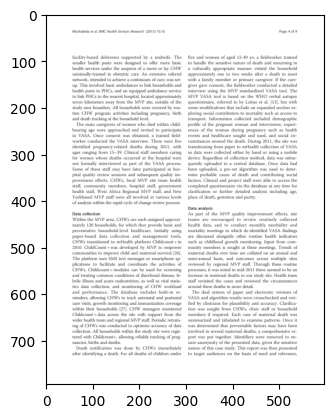

In [5]:
for image, json in pil_dataset:
    break
plt.imshow(image)

We can add onto the existing pipeline for augmentation and data preparation.

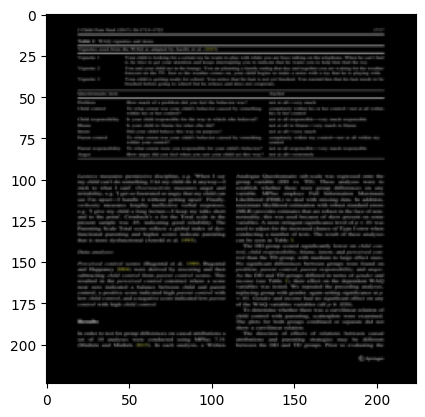

In [6]:
import torchvision.transforms as transforms
from PIL import Image

preproc = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    lambda x: 1-x,
])

def preprocess(sample):
    image, json = sample
    try:
        label = json["annotations"][0]["category_id"]
    except Exception:
        label = 0
    return preproc(image), label

dataset = pil_dataset.map(preprocess)

for image, label in dataset:
    break
plt.imshow(image.numpy().transpose(1, 2, 0))

`WebDataset` is just an instance of a standard `IterableDataset`. It's a single-threaded way of iterating over a dataset. Since image decompression and data augmentation can be compute intensive, PyTorch usually uses the `DataLoader` class to parallelize data loading and preprocessing. `WebDataset` is fully compatible with the standard `DataLoader`.

Here are a number of notebooks showing how to use WebDataset for image classification and LLM training:

- [train-resnet50-wds](examples/out/train-resnet50-wds.ipynb) -- simple, single GPU training from Imagenet
- [train-resnet50-multiray-wds](examples/out/train-resnet50-multiray-wds.ipynb) -- multinode training using webdataset
- [generate-text-dataset](examples/out/generate-text-dataset.ipynb) -- initial dataset generation
- [tesseract-wds](examples/out/tesseract-wds.ipynb) -- shard-to-shard transformations, here for OCR running over large datasets
- [train-ocr-errors-hf](examples/out/train-ocr-errors-hf.ipynb) -- an example of LLM fine tuning using a dataset in webdataset format

The [wds-notes](examples/wds-notes.ipynb) notebook contains some additional documentation and information about the library.

# The `webdataset` Pipeline API

The `wds.WebDataset` fluid interface is just a convenient shorthand for writing down pipelines. The underlying pipeline is an instance of the `wds.DataPipeline` class, and you can construct data pipelines explicitly, similar to the way you use `nn.Sequential` inside models.

In [7]:
dataset = wds.DataPipeline(
    wds.SimpleShardList(url),
    # at this point we have an iterator over all the shards

    # this shuffles the shards
    wds.shuffle(100),

    # add wds.split_by_node here if you are using multiple nodes
    wds.split_by_worker,

    # at this point, we have an iterator over the shards assigned to each worker
    wds.tarfile_to_samples(),

    # this shuffles the samples in memory
    wds.shuffle(shuffle_buffer),

    # this decodes the images and json
    wds.decode("pil"),
    wds.to_tuple("png", "json"),
    wds.map(preprocess),
    wds.batched(16)
)

batch = next(iter(dataset))
batch[0].shape, batch[1].shape

(torch.Size([16, 3, 224, 224]), (16,))

# Installation and Documentation

    $ pip install webdataset

For the Github version:

    $ pip install git+https://github.com/tmbdev/webdataset.git

Here are some videos talking about WebDataset and large scale deep learning:

- [Introduction to Large Scale Deep Learning](https://www.youtube.com/watch?v=kNuA2wflygM)
- [Loading Training Data with WebDataset](https://www.youtube.com/watch?v=mTv_ePYeBhs)
- [Creating Datasets in WebDataset Format](https://www.youtube.com/watch?v=v_PacO-3OGQ)
- [Tools for Working with Large Datasets](https://www.youtube.com/watch?v=kIv8zDpRUec)

# Dependencies

The WebDataset library only requires PyTorch, NumPy, and a small library called `braceexpand`.

WebDataset loads a few additional libraries dynamically only when they are actually needed and only in the decoder:

- PIL/Pillow for image decoding
- `torchvision`, `torchvideo`, `torchaudio` for image/video/audio decoding
- `msgpack` for MessagePack decoding
- the `curl` command line tool for accessing HTTP servers
- the Google/Amazon/Azure command line tools for accessing cloud storage buckets

Loading of one of these libraries is triggered by configuring a decoder that attempts to decode content in the given format and encountering a file in that format during decoding. (Eventually, the torch... dependencies will be refactored into those libraries.)